# Unsupervised Clustering of Board Game Reviews

_Ryan Harper_

In [96]:
import random
import numpy as np
from string import punctuation as punct
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
import operator
from math import ceil

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from keras.layers import Dense, Input, CuDNNLSTM, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

from IPython.display import display, Markdown, Latex

In [2]:
def beep(audio): 
    # for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')
    
def memory_check():
    print('')
    print('CPU Percent: {} || Virtual Memory: {}'.format(psutil.cpu_percent(),psutil.virtual_memory()))
    print('')

# 1. Import and Clean Data

In [3]:
import pandas as pd

boardgamereviews = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')
boardgamereviews.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = boardgamereviews.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),100)
review = boardgamereviews[boardgamereviews['reviewer_id'].isin(sample_id)]

#### _Ratings equal the difference between a user's rating and that user's average rating._

In [4]:
review['rating_normed']=review.rating - review['rating'].groupby(review['reviewer_id']).transform('mean')
review['rating_normed']=(review['rating_normed']-review['rating_normed'].min())/(review['rating_normed'].max()-review['rating_normed'].min())
review['rating_normed']=review['rating_normed'].apply(lambda val: val*10).apply(ceil)
if 0 not in review['rating'].unique():
    review['rating_normed']=review['rating_normed'].apply(lambda val: 1 if val==0 else val)
# review['estimate'] = review['rating_normed'] + review['rating'].groupby(review['reviewer_id']).transform('mean')

In [5]:
review['rating'] = review['rating'].apply(round)
memory_check()


CPU Percent: 37.0 || Virtual Memory: svmem(total=8589934592, available=3101446144, percent=63.9, used=8221790208, free=27164672, active=3272052736, inactive=3074281472, wired=1875456000)



# 2. Visualize

#### _The ratings appear normalized after reviews are adjusted according to user specific ratings_

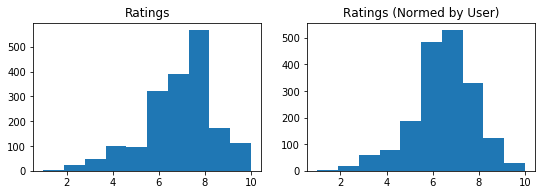

In [6]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.hist(review.rating,bins=10)
plt.title('Ratings')

plt.subplot(2,2,2)
plt.hist(review.rating_normed,bins=10)
plt.title('Ratings (Normed by User)');

# 3. Tokenize

In [7]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)

# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

comments_train = list(review["comment"].fillna("NAN_WORD").values)
review['token'] = process_comments(comments_train, lower=True)

Processing text dataset


100%|██████████| 1842/1842 [00:00<00:00, 21440.25it/s]


In [8]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))
print('')
memory_check()

The vocabulary contains 6781 unique tokens


CPU Percent: 37.2 || Virtual Memory: svmem(total=8589934592, available=3197743104, percent=62.8, used=8240140288, free=36069376, active=3205980160, inactive=3161673728, wired=1872486400)



# 4. Vocab Scoring Model

_CREDIT: Methodology and some code for this section closely follows Kenny Liao's Approach_

In [9]:
word_list = set([v for sublist in review.token.tolist() for v in sublist])

In [10]:
vocab_ratings = review[['rating']]
vocab_ratings.columns = ['Rating']

In [11]:
token_ratings = review[['rating','token']]
for v in tqdm(word_list):
    vocab_ratings[v]=[row[1][0] if v in row[1][1] else None for row in token_ratings.iterrows()]

100%|██████████| 6781/6781 [14:34<00:00,  7.76it/s]


In [12]:
[col for col, val in vocab_ratings.count().iteritems() if val < 1]

[]

#### Vocab Rating Baseline

In [13]:
# Split the data into a 70/30 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vocab_ratings.iloc[:,1:], vocab_ratings['Rating'], test_size=0.33, random_state=42)

In [14]:
from math import sqrt
def rmse(true, predicted):
    rmse = sqrt(((true-predicted)**2).mean())
    return rmse

Get the baseline RMSE if we just predict every comment is equal to the median for all ratings.

In [16]:
baseline_median = y_train.median();baseline_median

7.0

In [17]:
rmse_baseline = rmse(y_test, baseline_median)
display(Markdown(f"__Baseline RMSE:__ _{rmse_baseline:.5f}_"))

__Baseline RMSE:__ _1.66227_

#### Naive Set Median

In [18]:
vocab_describe = X_train.describe().T

In [19]:
# Get the median for every word
def percentile(n):
    
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = 'Q_%s' % n
    
    return percentile_

percentile(25)(vocab_ratings.king.dropna())

8.0

In [83]:
wordsets = []
ratings_range = range(1,11)
for i in ratings_range:
    q = vocab_describe[(vocab_describe['50%'] > i-1) & (vocab_describe['50%'] <= i)]
    q = q.sort_values(by=['count'],ascending=False)
    q = q[0:10]
    wordsets.append(q.index.values.tolist())  

In [84]:
wordsets[0]

['activity',
 'presumably',
 'parlor',
 'martha',
 'duck',
 'depressing',
 'goose',
 'loose',
 'stewart',
 'environments']

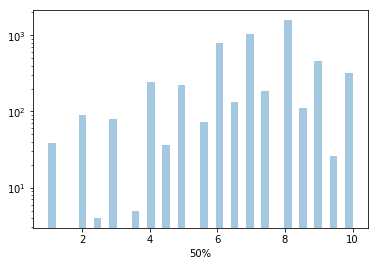

In [21]:
ax = sns.distplot(vocab_describe["50%"].dropna(), kde=False, bins=40, hist_kws={'log':True})

In [22]:
assign_values = dict(zip(vocab_describe.index, vocab_describe['50%']))

In [23]:
def isNaN(num):
    return num != num

X_train_median = X_train
X_test_median = X_test
for col in X_train:
    X_train_median[col] = X_train_median[col].apply(lambda val: assign_values[col] if not isNaN(val) else None)
    X_test_median[col] = X_test_median[col].apply(lambda val: assign_values[col] if not isNaN(val) else None)

In [24]:
y_train_predict = X_train_median.sum(axis=1)/X_train_median.count(axis=1)
y_test_predict = X_test_median.sum(axis=1)/X_test_median.count(axis=1)

In [25]:
train_median = rmse(y_train, y_train_predict)
display(Markdown(f"__Baseline RMSE:__ _{train_median:.5f}_"))

__Baseline RMSE:__ _1.51543_

In [26]:
import plotly.graph_objs as go
import plotly

In [27]:
trace0 = go.Scatter(
    x=y_train,
    y=y_train_predict,
    mode='markers')

trace1 = go.Scatter(
    x=[0,10],
    y=[0,10],
    name='Ideal Line')

layout = go.Layout(
    xaxis=dict(title='Actual'),
    yaxis=dict(title='Predicted'),
    hovermode='closest',
    margin=dict(t=50))

data=[trace0, trace1]

fig = go.Figure(data, layout)
# plotly.offline.iplot(fig, filename='predictions-naive.html')
plt.show()

## Word Medians w/ Linear Scaling

# 5. Vectorize

In [75]:
from gensim.models import Word2Vec

In [76]:
WV_DIM = 200
model = Word2Vec(review['token'], size=WV_DIM, window=10, min_count=1, workers=4, sg=0, negative=3)
vec_size = model.layer1_size
word_vectors = model.wv

In [77]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 6781


__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

_Version A. Raw Code_

#### _Used the cosine similarity function to check common words. 'Easy' and 'Simple' appear to be much more similar than 'Cat'.<br> <br>A good sign that the vectorization worked!_

In [86]:
cols_conv = ratings_range

colors = cm.rainbow(np.linspace(0, 1, len(cols_conv)))

fullcolors = []

for c in colors:
    for i in ratings_range:
        fullcolors.append(c)

In [89]:
fullwords = []
for wset in wordsets:
    for w in wset:
        fullwords.append(w)   

In [92]:
colors_dict = dict(zip(fullwords,fullcolors))

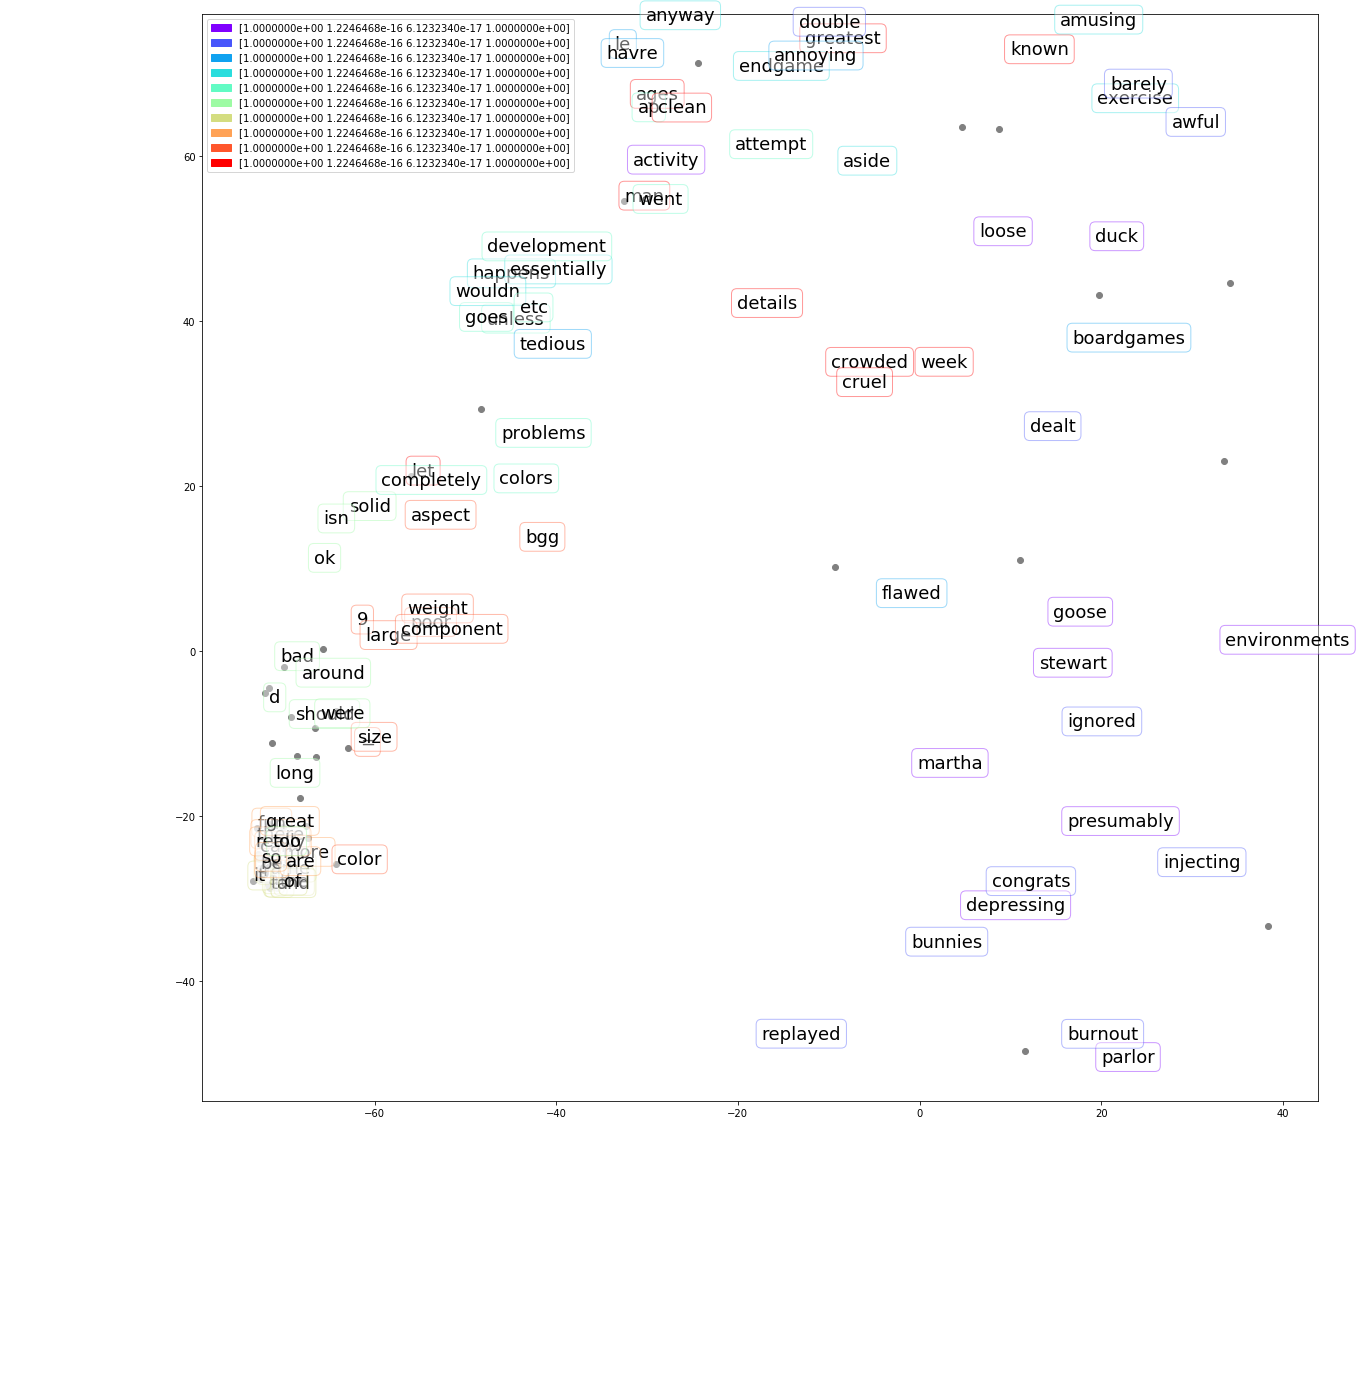

In [103]:
from sklearn.manifold import TSNE
X = model[model.wv.vocab]
words = list(model.wv.vocab)
graph_tsne = TSNE(n_components=2)
result = graph_tsne.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20,20))
plt.scatter(result[0:50, 0], result[0:50, 1],color='gray')
for i, word in enumerate(words):
    if word in colors_dict.keys():
        plt.annotate(word, 
                     xy=(result[i, 0], 
                         result[i, 1]),
                     size=18,bbox=dict(facecolor='white', edgecolor=colors_dict[word], boxstyle='round',alpha=.4))
handle_set = []
for i in colors:
    handle_set.append(mpatches.Patch(color=i, label=c))
plt.legend(handles=handle_set)
plt.show()

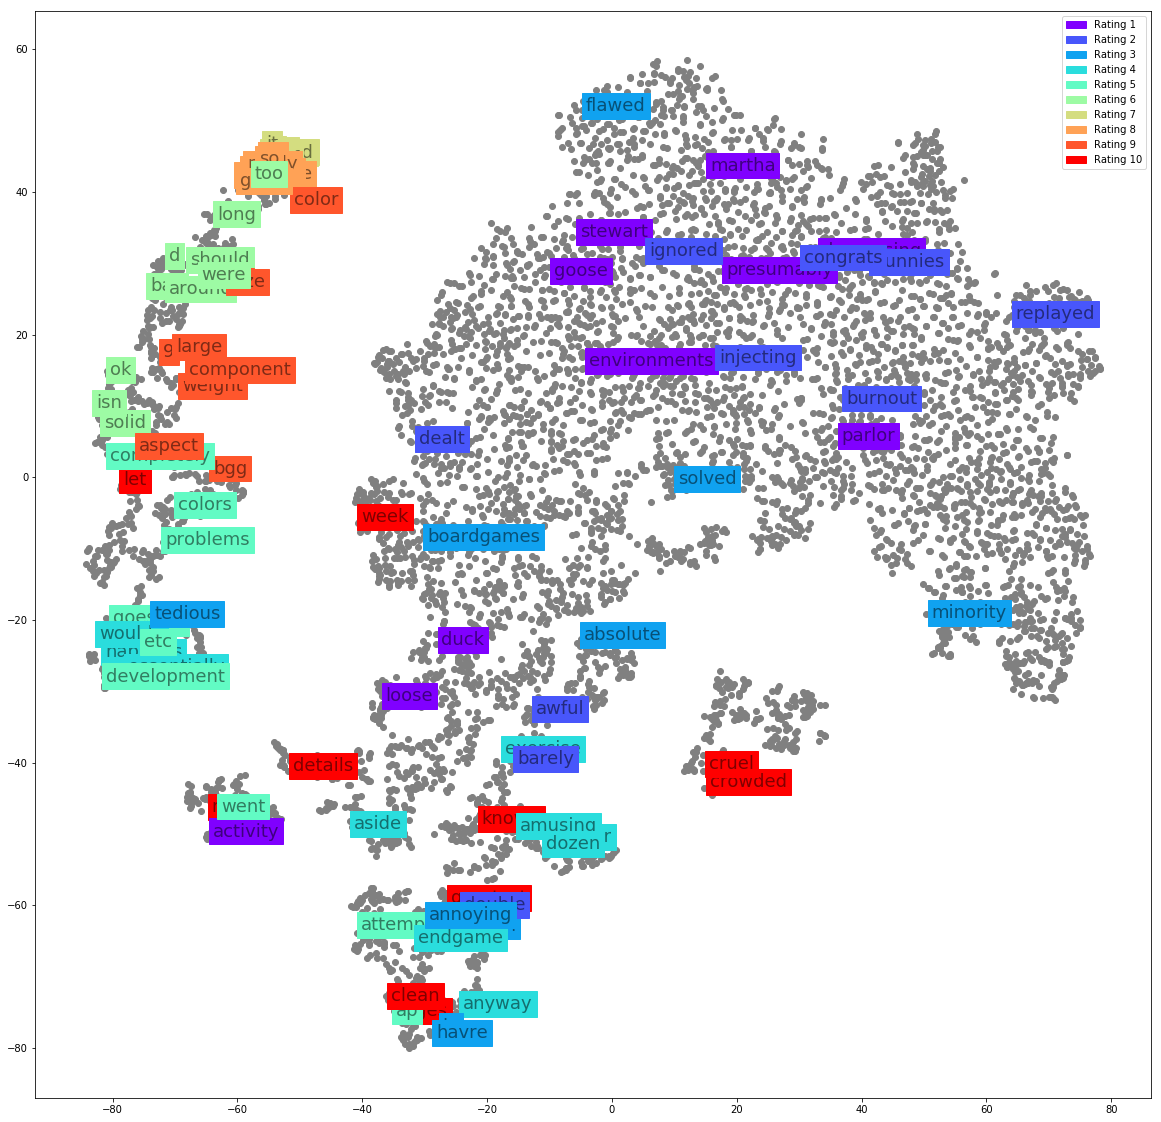

In [99]:
from sklearn.manifold import TSNE
X = model[model.wv.vocab]
words = list(model.wv.vocab)
graph_tsne = TSNE(n_components=2)
result = graph_tsne.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20,20))
plt.scatter(result[:, 0], result[:, 1],color='gray')
for i, word in enumerate(words):
    if word in colors_dict.keys():
        plt.annotate(word, 
                     xy=(result[i, 0], 
                         result[i, 1]),
                     size=18,
                     backgroundcolor=colors_dict[word],alpha=.4)
handle_set = []
for i in ratings_range:
    handle_set.append(mpatches.Patch(color=colors[i-1], label='Rating {}'.format(i)))
plt.legend(handles=handle_set)
plt.show()

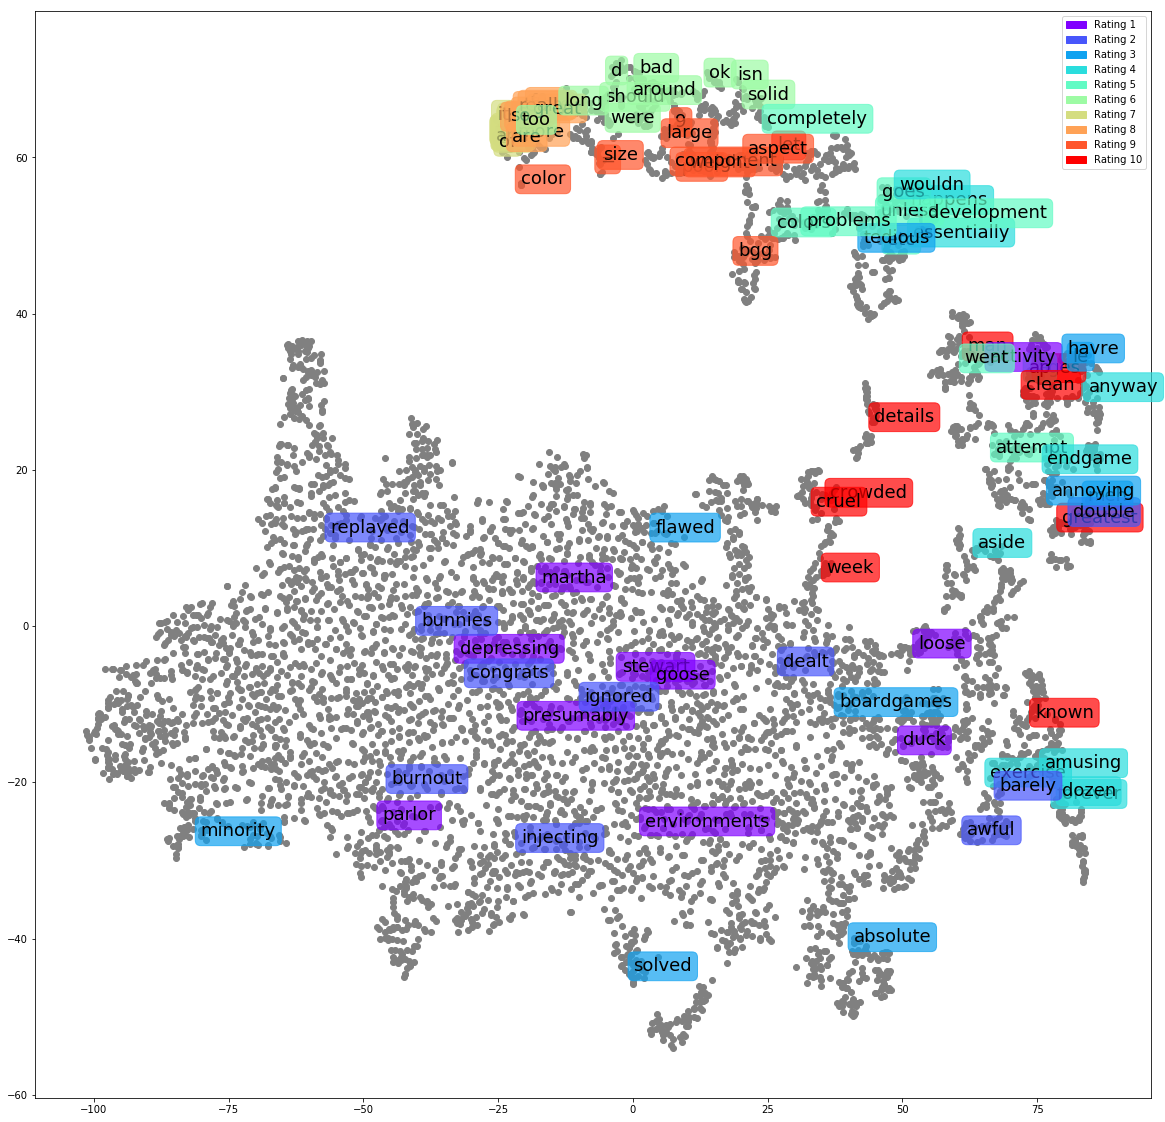

In [104]:
from sklearn.manifold import TSNE
X = model[model.wv.vocab]
words = list(model.wv.vocab)
graph_tsne = TSNE(n_components=2)
result = graph_tsne.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20,20))
plt.scatter(result[:, 0], result[:, 1],color='gray')
for i, word in enumerate(words):
    if word in colors_dict.keys():
        plt.annotate(word, 
                     xy=(result[i, 0], 
                         result[i, 1]),
                     size=18,
                     bbox=dict(facecolor=colors_dict[word], edgecolor=colors_dict[word], boxstyle='round',alpha=.8))
handle_set = []
for i in ratings_range:
    handle_set.append(mpatches.Patch(color=colors[i-1], label='Rating {}'.format(i)))
plt.legend(handles=handle_set)
plt.savefig('word2vec_ratings2.png')
plt.show()